##

# post GWAS analysis of sex-specific Analysis




In [1]:
from pathlib import Path
import pandas as pd
from scipy.stats import norm
import numpy as np
import gwaslab as gl

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/dask/array/chunk_types.py:110: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  import cupy


In [2]:
gl.show_version()

2025/01/07 21:30:37 GWASLab v3.4.45 https://cloufield.github.io/gwaslab/
2025/01/07 21:30:37 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com


## post-gwas


### 读取数据



In [11]:
rootDir = Path(
    "/home/xutingfeng/ukb/project/sex_diff/v1/output/02-GWAS/Results/GWASResult/test_run"
)
trait = "CAD"
getTraitDir = lambda sex: rootDir / f"{trait}/{trait}_{sex}.parquet"

In [13]:
Female_mysumstats = gl.Sumstats(
    pd.read_parquet(getTraitDir("female")),
    snpid="ID",
    chrom="CHROM",
    pos="GENPOS",
    ea="ALLELE1",
    nea="ALLELE0",
    eaf="A1FREQ",
    n="N",
    # p="P",
    mlog10p="LOG10P",
    beta="BETA",
    se="SE",
    build="38",
)

Male_mysumstats = gl.Sumstats(
    pd.read_parquet(getTraitDir("male")),
    snpid="ID",
    chrom="CHROM",
    pos="GENPOS",
    ea="ALLELE1",
    nea="ALLELE0",
    eaf="A1FREQ",
    n="N",
    # p="P",
    mlog10p="LOG10P",
    beta="BETA",
    se="SE",
    build="38",
)

2025/01/07 21:35:45 GWASLab v3.4.45 https://cloufield.github.io/gwaslab/
2025/01/07 21:35:45 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
2025/01/07 21:35:45 Start to initialize gl.Sumstats from pandas DataFrame ...
2025/01/07 21:35:46  -Reading columns          : SE,ID,ALLELE1,LOG10P,CHROM,N,ALLELE0,BETA,A1FREQ,GENPOS
2025/01/07 21:35:46  -Renaming columns to      : SE,SNPID,EA,MLOG10P,CHR,N,NEA,BETA,EAF,POS
2025/01/07 21:35:46  -Current Dataframe shape : 5761270  x  10
2025/01/07 21:35:47  -Initiating a status column: STATUS ...
2025/01/07 21:35:47  -Genomic coordinates are based on GRCh38/hg38...
2025/01/07 21:35:48 Start to reorder the columns...v3.4.45
2025/01/07 21:35:48  -Current Dataframe shape : 5761270 x 11 ; Memory usage: 417.34 MB
2025/01/07 21:35:48  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,MLOG10P,N,STATUS
2025/01/07 21:35:48 Finished reordering the columns.
2025/01/07 21:35:48  -Column  : SNPID  CHR    POS   EA       NEA      

1. remove dump (目前可能存在恰好男女合并后是dump的，但是新版本已经去掉所有多等位基因了)

In [14]:
Female_mysumstats.remove_dup(mode="md")
Male_mysumstats.remove_dup(mode="md")

2025/01/07 21:35:58 Start to remove duplicated/multiallelic variants...v3.4.45
2025/01/07 21:35:58  -Current Dataframe shape : 5761270 x 11 ; Memory usage: 417.34 MB
2025/01/07 21:35:58  -Removing mode:md
2025/01/07 21:35:58 ColumnP was not detected... skipping... 
2025/01/07 21:35:58 Start to remove duplicated variants based on snpid...v3.4.45
2025/01/07 21:35:58  -Current Dataframe shape : 5761270 x 11 ; Memory usage: 417.34 MB
2025/01/07 21:35:58  -Which variant to keep:  first
2025/01/07 21:36:00  -Removed  107  based on SNPID...
2025/01/07 21:36:00 Start to remove duplicated variants based on CHR,POS,EA and NEA...
2025/01/07 21:36:00  -Current Dataframe shape : 5761163 x 11 ; Memory usage: 461.29 MB
2025/01/07 21:36:00  -Which variant to keep:  first
2025/01/07 21:36:03  -Removed  2  based on CHR,POS,EA and NEA...
2025/01/07 21:36:03 Start to remove multiallelic variants based on chr:pos...
2025/01/07 21:36:03  -Current Dataframe shape : 5761161 x 11 ; Memory usage: 461.29 MB
2025

Assign P and MAF

In [15]:
%%time 
Female_mysumstats.data['P'] = 10**(- Female_mysumstats.data['MLOG10P'])
Male_mysumstats.data['P'] = 10**(- Male_mysumstats.data['MLOG10P'])

CPU times: user 135 ms, sys: 696 µs, total: 136 ms
Wall time: 135 ms


In [16]:
Female_mysumstats.data["Z"] = (
    Female_mysumstats.data["BETA"] / Female_mysumstats.data["SE"]
)
Male_mysumstats.data["Z"] = Male_mysumstats.data["BETA"] / Male_mysumstats.data["SE"]

In [17]:
Female_mysumstats.data["MAF"] = Female_mysumstats.data["EAF"].apply(
    lambda x: min(x, 1 - x) if pd.notnull(x) else np.nan
)
Male_mysumstats.data["MAF"] = Male_mysumstats.data["EAF"].apply(
    lambda x: min(x, 1 - x) if pd.notnull(x) else np.nan
)

Cal lambda

暂时不用表格

In [19]:
from scipy import stats


def calculate_lambda_from_z(z_scores):
    chisq = z_scores**2
    median_chisq = np.median(chisq)
    lambda_gc = median_chisq / 0.4549364
    return lambda_gc


def calculate_lambda_from_p(p_values):
    z_scores = np.abs(stats.norm.ppf(p_values / 2))
    return calculate_lambda_from_z(z_scores)

In [20]:
Female_lambda = calculate_lambda_from_p(Female_mysumstats.data["P"])
Male_lambda = calculate_lambda_from_p(Male_mysumstats.data["P"])
print(
    f"Female genomic inflation factor is {Female_lambda:.2f}\nMale genomic inflation factor is {Male_lambda:.2f}"
)

Female genomic inflation factor is 1.12
Male genomic inflation factor is 1.05


### 绘制性别间的曼哈顿图

需要保存

2025/01/07 21:38:51 Start to create MQQ plot...v3.4.45:
2025/01/07 21:38:51  -Genomic coordinates version: 38...
2025/01/07 21:38:51  -Genome-wide significance level to plot is set to 5e-08 ...
2025/01/07 21:38:51  -Raw input contains 5734853 variants...
2025/01/07 21:38:51  -MQQ plot layout mode is : mqq
2025/01/07 21:38:52 Finished loading specified columns from the sumstats.
2025/01/07 21:38:52 Start data conversion and sanity check:
2025/01/07 21:38:52  -Removed 0 variants with nan in CHR or POS column ...
2025/01/07 21:38:53  -Removed 0 variants with CHR <=0...
2025/01/07 21:38:53  -Removed 0 variants with nan in P column ...
2025/01/07 21:38:53  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
2025/01/07 21:38:53  -Sumstats P values are being converted to -log10(P)...
2025/01/07 21:38:54  -Sanity check: 0 na/inf/-inf variants will be removed...
2025/01/07 21:38:54  -Converting data above cut line...
2025/01/07 21:38:54  -Maximum -log10(P

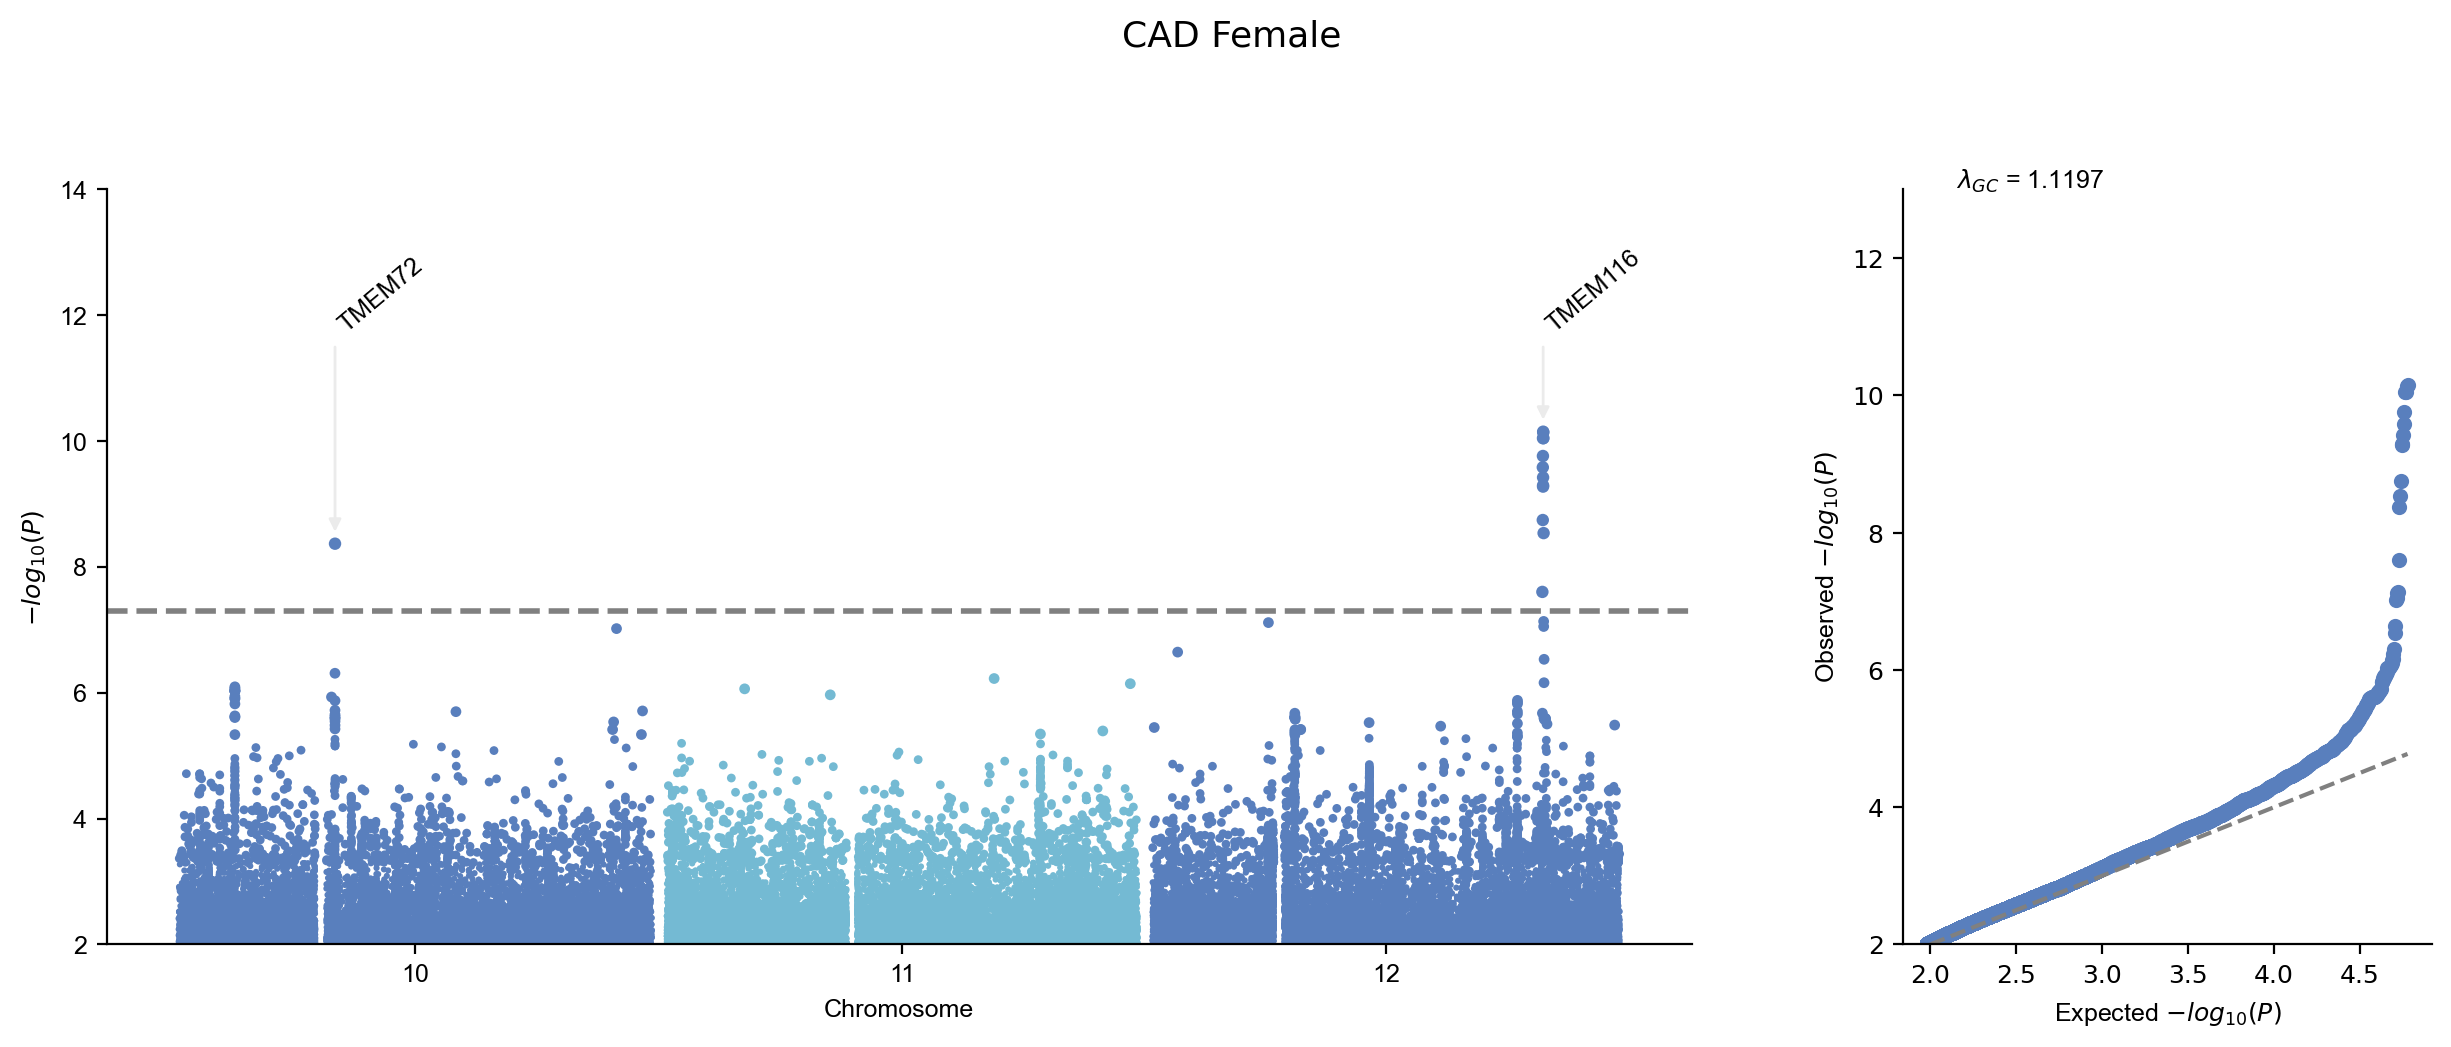

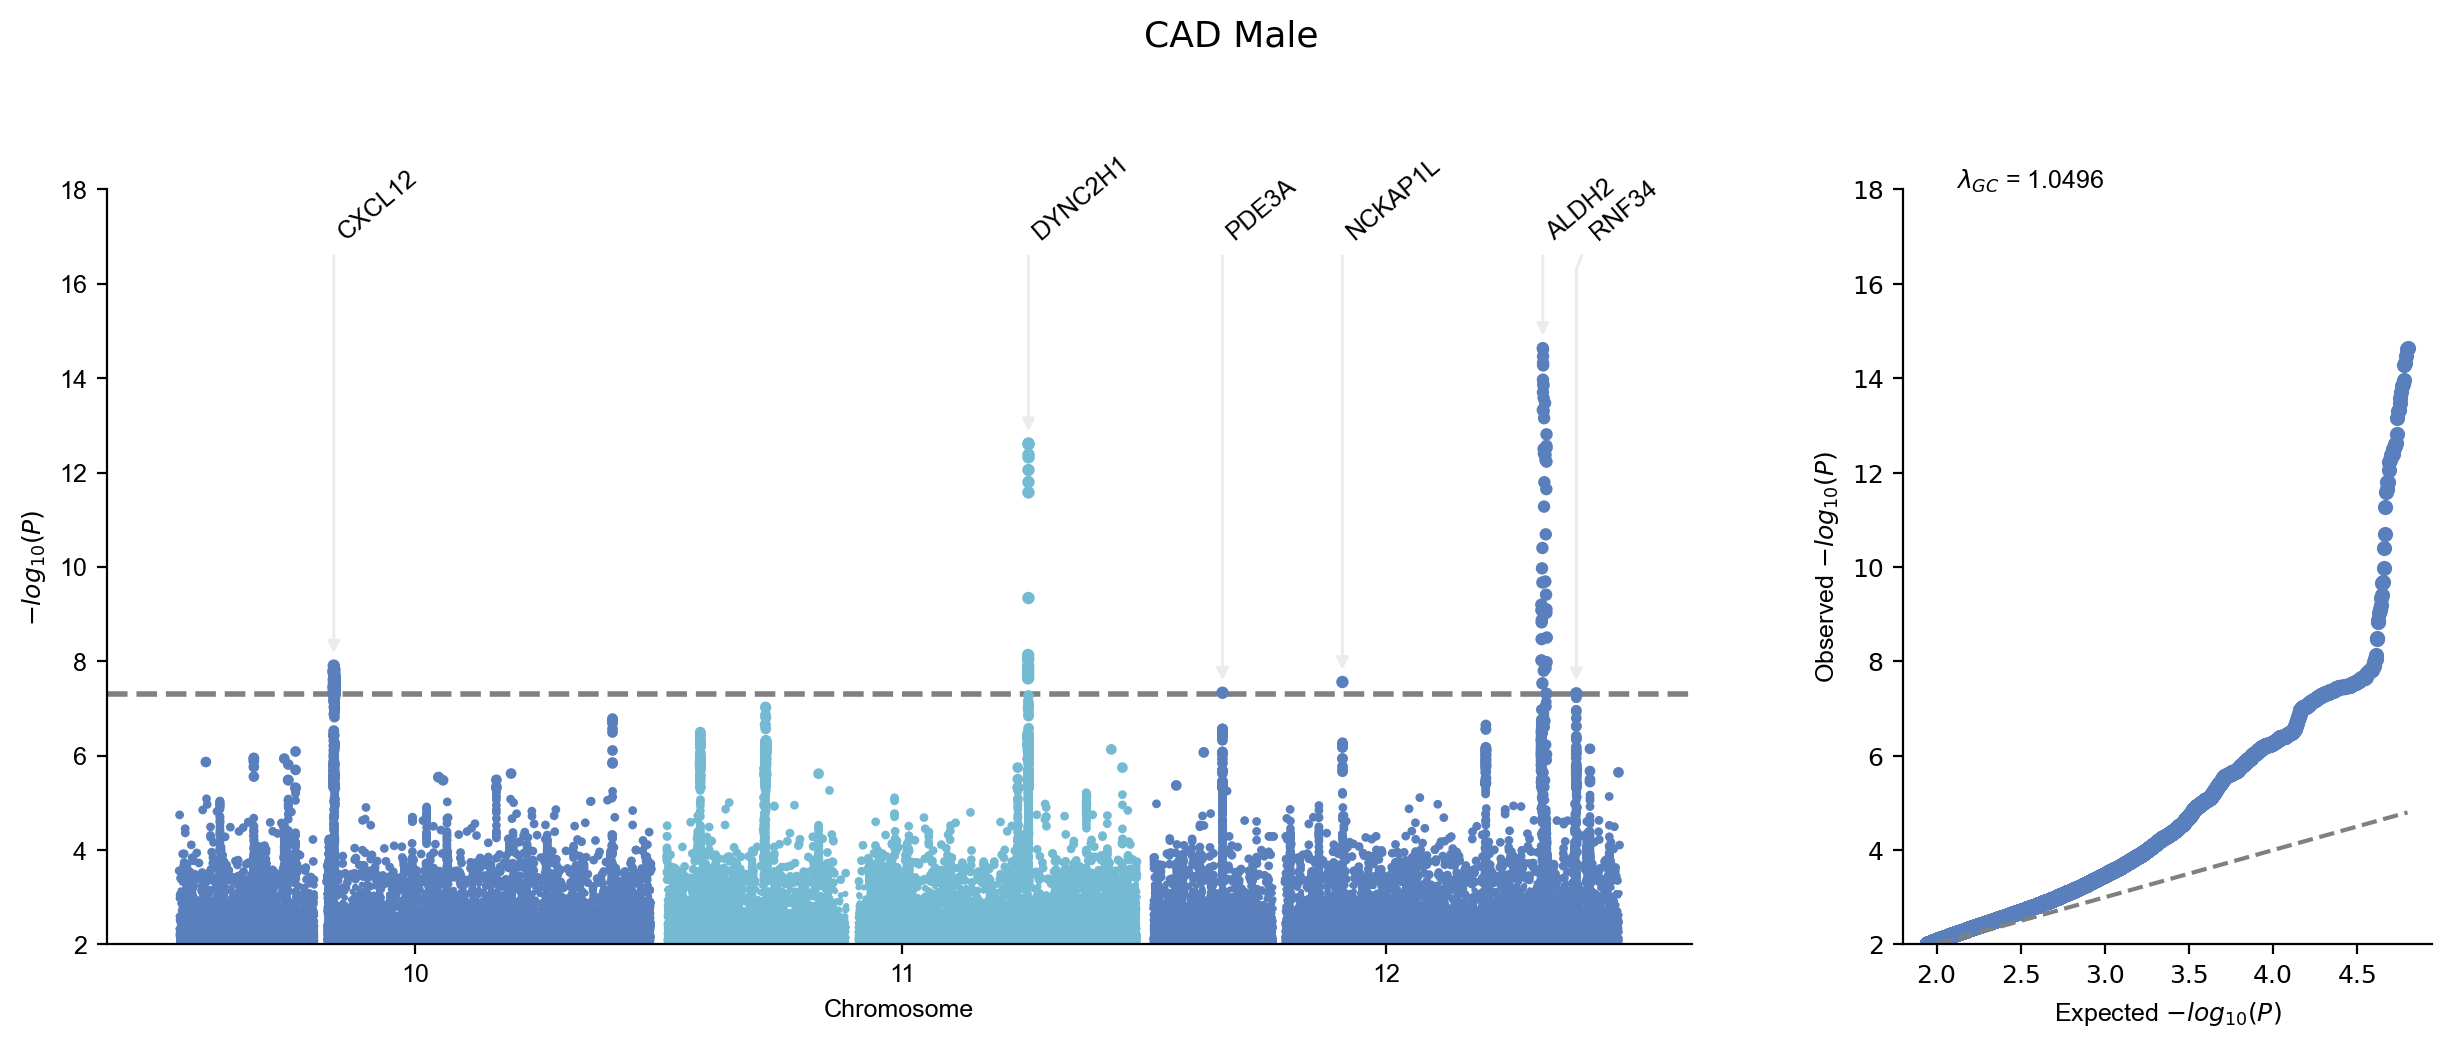

In [21]:
Female_mahanttanPlot = Female_mysumstats.plot_mqq(
    skip=2, title=f"{trait} Female", anno="GENENAME"
)
Male_mahanttanPlot = Male_mysumstats.plot_mqq(
    skip=2, title=f"{trait} Male", anno="GENENAME"
)

分性别的气泡图，展示性别差异之间是否存在相关差异

保存

In [22]:
sig_level = 5e-6
Female_mysumstats_lead_data = Female_mysumstats.get_lead(
    sig_level=sig_level, gls=True, anno=True
)
Male_mysumstats_lead_data = Male_mysumstats.get_lead(
    sig_level=sig_level, gls=True, anno=True
)

Female_sig_loci_numbers = Female_mysumstats_lead_data.data.shape[0]
Male_sig_loci_numbers = Male_mysumstats_lead_data.data.shape[0]
if Female_sig_loci_numbers == 0:
    print(f"Female {trait} no lead SNP")
else:
    print(
        f"Female {trait} found {Female_sig_loci_numbers} loci with windowsizekb=500 and sig_level={sig_level:.2e}"
    )
if Male_sig_loci_numbers == 0:
    print(f"Male {trait} no lead SNP")
else:
    print(
        f"Male {trait} found {Male_sig_loci_numbers} loci with windowsizekb=500 and sig_level={sig_level:.2e}"
    )

2025/01/07 21:39:08 Start to extract lead variants...v3.4.45
2025/01/07 21:39:08  -Current Dataframe shape : 5734853 x 14 ; Memory usage: 552.26 MB
2025/01/07 21:39:08  -Processing 5734853 variants...
2025/01/07 21:39:08  -Significance threshold : 5e-06
2025/01/07 21:39:08  -Sliding window size: 500  kb
2025/01/07 21:39:10  -Using MLOG10P for extracting lead variants...
2025/01/07 21:39:10  -Found 89 significant variants in total...
2025/01/07 21:39:11  -Identified 23 lead variants!
2025/01/07 21:39:11  -Annotating variants using references:ensembl
2025/01/07 21:39:11  -Annotating variants using references based on genome build:38
2025/01/07 21:39:11 Start to annotate variants with nearest gene name(s)...
2025/01/07 21:39:11  -Assigning Gene name using ensembl_hg38_gtf for protein coding genes
2025/01/07 21:39:12 Finished annotating variants with nearest gene name(s) successfully!
2025/01/07 21:39:12 Finished extracting lead variants.
2025/01/07 21:39:12 Start to extract lead variants.

2025/01/07 21:39:18 Start to create trumpet plot...
2025/01/07 21:39:18  -Prevalence is not given. Estimating based on scase and scontrol :0.19093260465989445...
2025/01/07 21:39:18  -Settings:
2025/01/07 21:39:18   -Mode: b
2025/01/07 21:39:18   -N_CASE: 36614
2025/01/07 21:39:18   -N_CONTROL: 155150
2025/01/07 21:39:18   -PREVALENCE: 0.19093260465989445
2025/01/07 21:39:18   -BETA: BETA
2025/01/07 21:39:18   -Significance level: 5e-08
2025/01/07 21:39:18   -Power thresholds: [0.8]
2025/01/07 21:39:18   -Power line smoothness: 2000
2025/01/07 21:39:18  -Excluding variants with P values > 5e-08
2025/01/07 21:39:18  -Plotting 2 variants...
2025/01/07 21:39:18  -Flipping 2 variants...
2025/01/07 21:39:18  -Updating eaf-beta matrix...
2025/01/07 21:39:18  -OR is converted to GRR using base prevalence: 0.19093260465989445
2025/01/07 21:39:18  -Extracting eaf-beta combinations with power = 0.8...
2025/01/07 21:39:18 Start to save figure...
2025/01/07 21:39:18  -Skip saving figure!
2025/01/0

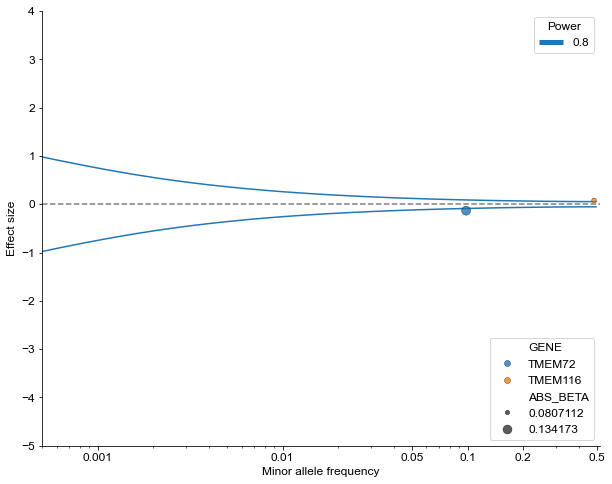

In [23]:
Female_mysumstats_lead_data_trumpetPlot = Female_mysumstats_lead_data.plot_trumpet(
    mode="b",
    ncase=36614,
    # ncase=n_case,
    # ncontrol=n_control,
    ncontrol=155150,
    # sig_level=5e-6,
    # p_level=5e-6,
    ts=[0.8],
    anno="GENENAME",
    anno_style="expand",
    cmap="tab20",
    or_to_rr=True,
    build="38",
    anno_x=0.01,
    anno_y=0,
    n_matrix=2000,
    fontsize=12,
    xscale="log",
    repel_force=0.15,
    sort="eaf",
    hue="GENE",
    ylim=(-5, 4),
    # title="Female",
)

2025/01/07 21:39:38 Start to create trumpet plot...
2025/01/07 21:39:38  -Prevalence is not given. Estimating based on scase and scontrol :0.19093260465989445...
2025/01/07 21:39:38  -Settings:
2025/01/07 21:39:38   -Mode: b
2025/01/07 21:39:38   -N_CASE: 36614
2025/01/07 21:39:38   -N_CONTROL: 155150
2025/01/07 21:39:38   -PREVALENCE: 0.19093260465989445
2025/01/07 21:39:38   -BETA: BETA
2025/01/07 21:39:38   -Significance level: 5e-08
2025/01/07 21:39:38   -Power thresholds: [0.8]
2025/01/07 21:39:38   -Power line smoothness: 2000
2025/01/07 21:39:38  -Excluding variants with P values > 5e-08
2025/01/07 21:39:38  -Plotting 6 variants...
2025/01/07 21:39:38  -Flipping 4 variants...
2025/01/07 21:39:38  -Updating eaf-beta matrix...
2025/01/07 21:39:38  -OR is converted to GRR using base prevalence: 0.19093260465989445
2025/01/07 21:39:39  -Extracting eaf-beta combinations with power = 0.8...
2025/01/07 21:39:39 Start to save figure...
2025/01/07 21:39:39  -Skip saving figure!
2025/01/0

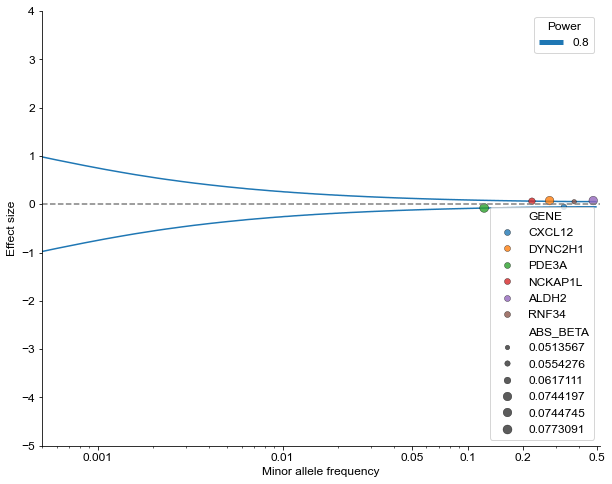

In [24]:
Male_mysumstats_lead_data_trumpetPlot = Male_mysumstats_lead_data.plot_trumpet(
    mode="b",
    ncase=36614,
    # ncase=n_case,
    # ncontrol=n_control,
    ncontrol=155150,
    # sig_level=5e-6,
    # p_level=5e-8,
    ts=[0.8],
    # ts=[0.2, 0.4, 0.6, 0.8],
    anno="GENENAME",
    anno_style="right",
    cmap="tab20",
    or_to_rr=True,
    build="38",
    anno_x=0.01,
    anno_y=0,
    n_matrix=2000,
    fontsize=12,
    xscale="log",
    repel_force=0.15,
    sort="eaf",
    hue="GENE",
    ylim=(-5, 4),
    # title="Male",
)

### 绘制性别对比的曼哈顿图

保存

In [ ]:
Female_Male_miamiPlot = gl.plot_miami2(
    path1=Male_mysumstats,
    path2=Female_mysumstats,
    skip=2,
    #  id1="SNPID",
    #  id2="SNPID",
    anno1="GENENAME",
    anno2="GENENAME",
    build="38",
    titles=[
        "Male",
        "Female",
    ],
)

2025/01/07 21:40:07 Start to create miami plot v3.4.45:
2025/01/07 21:40:07  -Obtaining Sumstats1 CHR, POS, P and annotation from: ['CHR', 'POS', 'P']
2025/01/07 21:40:07  -Loading Sumstats1 from gwaslab.Sumstats Object
2025/01/07 21:40:07  -Obtaining Sumstats2 CHR, POS, P and annotation from: ['CHR', 'POS', 'P']
2025/01/07 21:40:07  -Loading Sumstats2 from gwaslab.Sumstats Object
2025/01/07 21:40:08  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
2025/01/07 21:40:08  -Sumstats P values are being converted to -log10(P)...
2025/01/07 21:40:09  -Sanity check: 0 na/inf/-inf variants will be removed...
2025/01/07 21:40:09  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
2025/01/07 21:40:10  -Sumstats P values are being converted to -log10(P)...
2025/01/07 21:40:10  -Sanity check: 0 na/inf/-inf variants will be removed...
2025/01/07 21:40:10  -Merging sumstats using chr and pos...


### 计算异质性

见2021NG

![](https://tf-picture-bed-1259792641.cos.ap-beijing.myqcloud.com/20250107154222.png)

In [30]:
# cal spearman correlation

innerSet = Female_mysumstats.data.merge(
    Male_mysumstats.data,
    on=["SNPID", "CHR", "POS", "EA", "NEA"],
    suffixes=["_female", "_male"],
)

save this results to a file


In [ ]:
# spearman rank correlation
# save this results to a file

from scipy.stats import spearmanr

r, p = spearmanr(innerSet["P_male"], innerSet["P_female"])
print(f"Spearman rank correlation cross sex is {r:.4f}, p-value is {p:.4e}")

Spearman rank correlation cross sex is 0.0043, p-value is 9.9107e-14


In [57]:
# innerSet["New_P_male"] = 2 * norm.sf(
#     np.abs(innerSet["BETA_male"] / innerSet["SE_male"])
# )  # two-sided

# innerSet[["P_male", "New_P_male"]]

In [59]:
# hetrogeneity test


def het_test(BETA_F, SE_F, BETA_M, SE_M, P_F=None, P_M=None, r=None):
    """
    Follow the formula in the paper of (Bernabeu et al., Nat Genet, 2021)

    BETA_F: np.array or pd.Series,
    SE_F: np.array or pd.Series,
    BETA_M: np.array or pd.Series,
    SE_M: np.array or pd.Series,
    r: float, default None, the spearman correlation between the Female and Male of p-values (zscore is same as p-value)
    """

    if r is None:
        # r, _ = spearmanr(BETA_F, BETA_M)
        if P_F is None:
            P_F = 2 * norm.sf(np.abs(BETA_F / SE_F))
        if P_M is None:
            P_M = 2 * norm.sf(np.abs(BETA_M / SE_M))

        r, p_spearmanr = spearmanr(P_F, P_M)

        print(
            f"The spearman correlation of Z-scores is {r:.6f}, p-value is {p_spearmanr:.4e}"
        )
    # calculate the two-tailed t-test
    t = (BETA_M - BETA_F) / np.sqrt(SE_M**2 + SE_F**2 - 2 * r * SE_M * SE_F)

    # pvalue
    p = 2 * norm.sf(np.abs(t))

    return p

计算Het P

In [60]:
innerSet["het_p"] = het_test(
    BETA_F=innerSet["BETA_female"],
    SE_F=innerSet["SE_female"],
    BETA_M=innerSet["BETA_male"],
    SE_M=innerSet["SE_male"],
)
innerSet

The spearman correlation of Z-scores is 0.004313, p-value is 1.0481e-13


,SNPID,CHR,POS,EA,NEA,EAF_female,BETA_female,SE_female,MLOG10P_female,N_female,...,EAF_male,BETA_male,SE_male,MLOG10P_male,N_male,STATUS_male,P_male,MAF_male,New_P_male,het_p
0,1:10177:A:AC,1,10177,AC,A,0.410008,-0.043925,0.032167,0.764246,50238,...,0.410927,-0.040451,0.023654,1.059280,42920,3899999,0.087241,0.410927,0.087240,0.930517
1,1:10352:T:TA,1,10352,TA,T,0.410792,0.022213,0.034334,0.285955,47535,...,0.411919,0.000537,0.025372,0.007402,40349,3899999,0.983102,0.411919,0.983102,0.610914
2,1:10511:G:A,1,10511,A,G,0.000472,-0.363744,0.289819,0.678918,210881,...,0.000415,0.234423,0.219168,0.545463,179471,3899999,0.284798,0.000415,0.284798,0.099016
3,1:10539:C:A,1,10539,A,C,0.000033,2.164100,1.046750,1.412390,211501,...,0.000031,-0.209174,0.768689,0.104836,179974,3899999,0.785532,0.000031,0.785531,0.067067
4,1:10616:CCGCCGTTGCAAAGGCGCGCCG:C,1,10616,C,CCGCCGTTGCAAAGGCGCGCCG,0.998605,-0.066735,0.164876,0.163893,207481,...,0.998627,0.101095,0.121881,0.390569,176684,3899999,0.406847,0.001373,0.406846,0.412081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971580,1:248945900:T:TA,1,248945900,TA,T,0.510806,-0.008551,0.045849,0.069533,51081,...,0.508927,0.009184,0.033944,0.104172,43520,3899999,0.786734,0.491073,0.786733,0.755405
2971581,1:248946020:A:T,1,248946020,T,A,0.232711,-0.062615,0.042506,0.851613,31668,...,0.232695,0.028194,0.031262,0.435185,27016,3899999,0.367126,0.232695,0.367126,0.084603
2971582,1:248946338:GGT:G,1,248946338,G,GGT,0.472807,0.032465,0.045068,0.326696,51998,...,0.473652,0.055200,0.033734,0.992371,44083,3899999,0.101772,0.473652,0.101773,0.685706
2971583,1:248946340:T:G,1,248946340,G,T,0.372000,0.089807,0.043374,1.415650,33211,...,0.370105,-0.015133,0.031834,0.197548,28169,3899999,0.634530,0.370105,0.634531,0.050643


SexDiff_sumstats 需要保存，并且提供方向（和XY讨论）

In [62]:
SexDiff_sumstats = gl.Sumstats(
    innerSet,
    snpid="SNPID",
    chrom="CHR",
    pos="POS",
    ea="EA",
    nea="NEA",
    p="het_p",
    build="38",
)

2025/01/07 16:17:02 GWASLab v3.5.4 https://cloufield.github.io/gwaslab/
2025/01/07 16:17:02 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
2025/01/07 16:17:02 Start to initialize gl.Sumstats from pandas DataFrame ...
2025/01/07 16:17:03  -Reading columns          : SNPID,CHR,POS,EA,het_p,NEA
2025/01/07 16:17:03  -Renaming columns to      : SNPID,CHR,POS,EA,P,NEA
2025/01/07 16:17:03  -Current Dataframe shape : 2971585  x  6
2025/01/07 16:17:03  -Initiating a status column: STATUS ...
2025/01/07 16:17:03  -Genomic coordinates are based on GRCh38/hg38...
2025/01/07 16:17:04 Start to reorder the columns...v3.5.4
2025/01/07 16:17:04  -Current Dataframe shape : 2971585 x 7 ; Memory usage: 135.75 MB
2025/01/07 16:17:04  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,P,STATUS
2025/01/07 16:17:04 Finished reordering the columns.
2025/01/07 16:17:04  -Column  : SNPID  CHR    POS   EA       NEA      P       STATUS  
2025/01/07 16:17:04  -DType   : object string int64 cate

需要保存

2025/01/07 16:18:12 Start to create MQQ plot...v3.5.4:
2025/01/07 16:18:12  -Genomic coordinates version: 38...
2025/01/07 16:18:12  -Genome-wide significance level to plot is set to 5e-08 ...
2025/01/07 16:18:12  -Raw input contains 2971585 variants...
2025/01/07 16:18:12  -MQQ plot layout mode is : mqq
2025/01/07 16:18:13 Finished loading specified columns from the sumstats.
2025/01/07 16:18:13 Start data conversion and sanity check:
2025/01/07 16:18:13  -Removed 0 variants with nan in CHR or POS column ...
2025/01/07 16:18:13  -Removed 0 variants with CHR <=0...
2025/01/07 16:18:13  -Removed 0 variants with nan in P column ...
2025/01/07 16:18:13  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
2025/01/07 16:18:13  -Sumstats P values are being converted to -log10(P)...
2025/01/07 16:18:14  -Sanity check: 0 na/inf/-inf variants will be removed...
2025/01/07 16:18:14  -Converting data above cut line...
2025/01/07 16:18:14  -Maximum -log10(P)

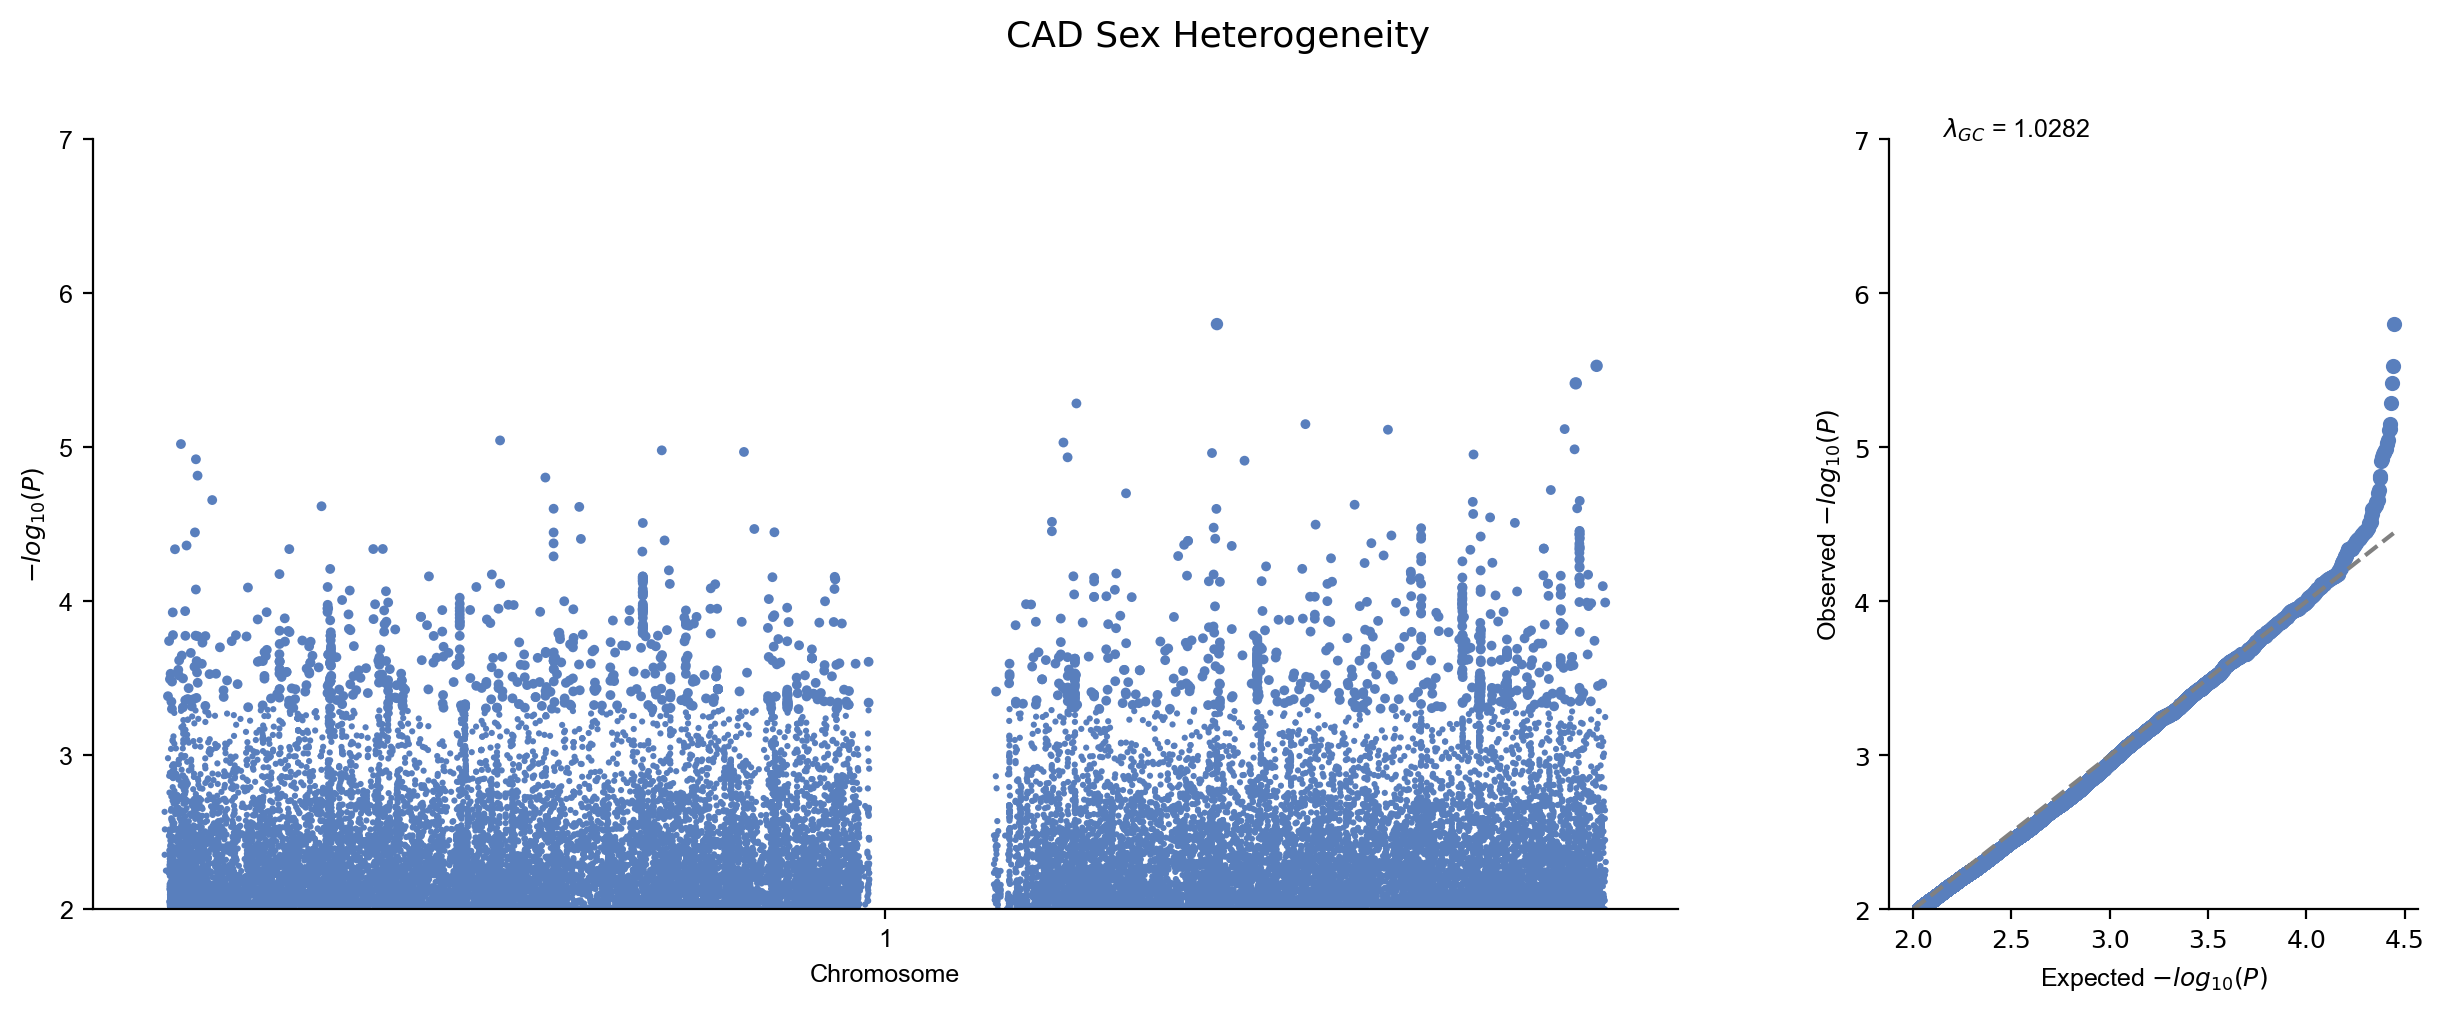

In [64]:
SexDiff_mahanttanPlot = SexDiff_sumstats.plot_mqq(
    skip=2, title=f"{trait} Sex Heterogeneity", anno="GENENAME"
)

Genome-wide significance cut-off is $P \lt 1 \times 10^{-8}$

保存显著的位点以及对应的表型

In [75]:
SigLoci = SexDiff_sumstats.get_lead(sig_level=1e-8)

if SigLoci.shape[0] == 0:
    print(f"No significant loci found of {trait}")

2025/01/07 16:21:40 Start to extract lead variants...v3.5.4
2025/01/07 16:21:40  -Current Dataframe shape : 2971585 x 7 ; Memory usage: 135.75 MB
2025/01/07 16:21:40  -Processing 2971585 variants...
2025/01/07 16:21:40  -Significance threshold : 1e-08
2025/01/07 16:21:40  -Sliding window size: 500  kb
2025/01/07 16:21:41  -Using P for extracting lead variants...
2025/01/07 16:21:41  -Found 0 significant variants in total...
2025/01/07 16:21:41  -Identified 0 lead variants!
2025/01/07 16:21:41 Finished extracting lead variants.
No significant loci found of CAD


#### compare het
TODO：这张图有待进一步理解

保存

2025/01/07 16:46:59 Start to process the raw sumstats for plotting...
2025/01/07 16:46:59 Path1 is gwaslab Sumstats object...
2025/01/07 16:46:59 Path2 is gwaslab Sumstats object...
2025/01/07 16:46:59  -Loading sumstats for Male : SNPID
2025/01/07 16:46:59  -Loading sumstats for Female : SNPID,P,CHR,POS
2025/01/07 16:47:01  -Counting  variants available for both datasets: 2954688  variants...
2025/01/07 16:47:02  -Using only variants available for both datasets...
2025/01/07 16:47:02  -Extract lead variants from Female...
2025/01/07 16:47:02 Start to extract lead variants...v3.5.4
2025/01/07 16:47:02  -Current Dataframe shape : 2954688 x 4 ; Memory usage: 115.53 MB
2025/01/07 16:47:02  -Processing 2954688 variants...
2025/01/07 16:47:02  -Significance threshold : 5e-08
2025/01/07 16:47:02  -Sliding window size: 500  kb
2025/01/07 16:47:03  -Using P for extracting lead variants...
2025/01/07 16:47:03  -Found 48 significant variants in total...
2025/01/07 16:47:03  -Identified 1 lead va

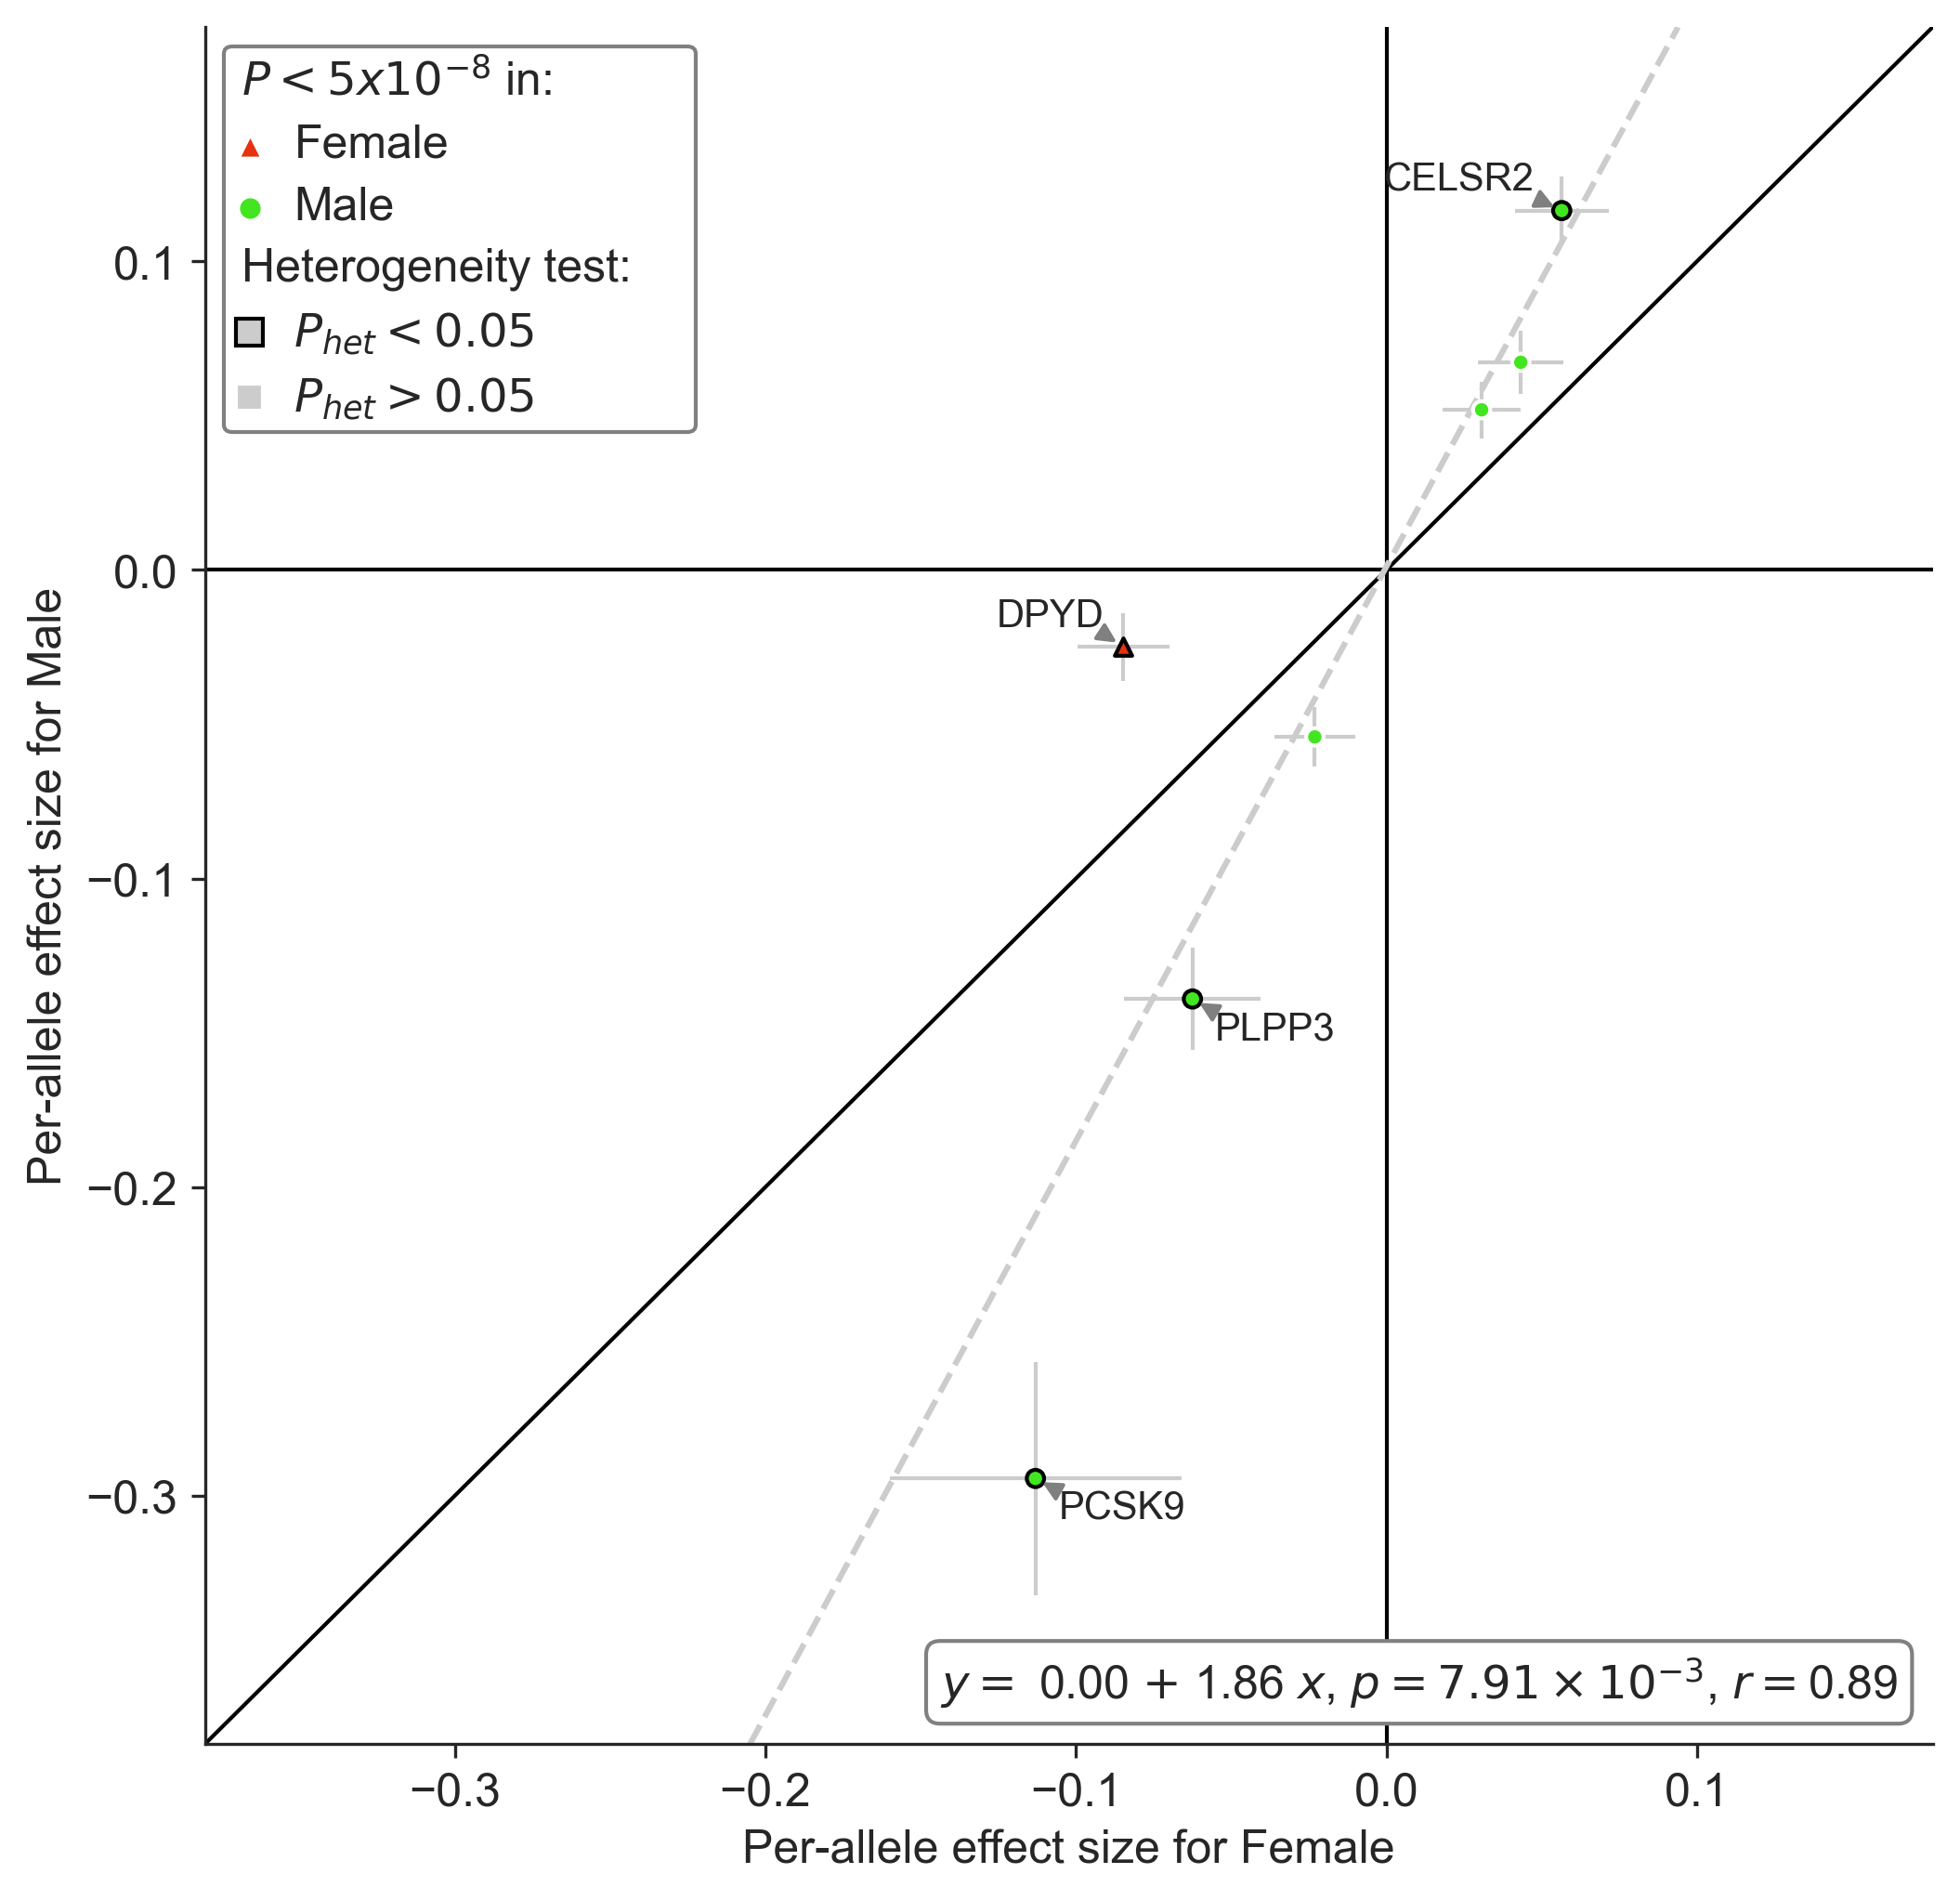

In [82]:
female_male_comparePlot = gl.compare_effect(
    path1=Female_mysumstats,
    cols_name_list_1=["SNPID", "P", "NEA", "EA", "CHR", "POS"],
    effect_cols_list_1=["BETA", "SE"],
    path2=Male_mysumstats,
    cols_name_list_2=["SNPID", "P", "NEA", "EA", "CHR", "POS"],
    effect_cols_list_2=["BETA", "SE"],
    label=["Female", "Male", "Both", "None"],
    xylabel_prefix="Per-allele effect size for ",
    anno="GENENAME",
    anno_het=True,
    anno_diff=0.015,
    is_q=True,
    sig_level=5e-8,
    legend_title=r"$ P < 5 x 10^{-8}$ in:",
    verbose=True,
    build="38",
    # mode="OR",
    #   save = "myplot.png",
    #   save_args= {"dpi":300,"facecolor":"white"}
)

### 计算性别间的遗传力和遗传相关性

1. SNP 位点需要hapmap3 
1. 需要预先计算好的LDSC，EUR的即可，来源见XXX（补充）；



In [86]:
ref_ld_chr = "/home/xutingfeng/github_code/mine/post_gwas/01-LDSC/genetic_corrlelation/eur_w_ld_chr/"
w_ld_chr = ref_ld_chr

In [84]:
# keep only hapmap3 SNPs

Female_mysumstats.filter_hapmap3(inplace=True)
Male_mysumstats.filter_hapmap3(inplace=True)

2025/01/07 16:51:57 Start to extract HapMap3 SNPs...v3.5.4
2025/01/07 16:51:57  -Current Dataframe shape : 3151716 x 14 ; Memory usage: 313.95 MB
2025/01/07 16:51:57  -Loading Hapmap3 variants from built-in datasets...
2025/01/07 16:51:58  -Since rsID not in sumstats, CHR:POS( build 38) will be used for matching...
2025/01/07 16:52:01  -Checking if alleles are same...
2025/01/07 16:52:01  -Variants with macthed alleles: 99663
2025/01/07 16:52:01  -Raw input contains 99663 Hapmap3 variants based on CHR:POS...
2025/01/07 16:52:01 Finished extracting HapMap3 SNPs.
2025/01/07 16:52:02 Start to extract HapMap3 SNPs...v3.5.4
2025/01/07 16:52:02  -Current Dataframe shape : 3039170 x 14 ; Memory usage: 303.53 MB
2025/01/07 16:52:02  -Loading Hapmap3 variants from built-in datasets...
2025/01/07 16:52:03  -Since rsID not in sumstats, CHR:POS( build 38) will be used for matching...
2025/01/07 16:52:07  -Checking if alleles are same...
2025/01/07 16:52:07  -Variants with macthed alleles: 99678
20

#### 估计性别间的遗传力

In [87]:
Female_mysumstats.estimate_h2_by_ldsc(ref_ld_chr=ref_ld_chr, w_ld_chr=w_ld_chr)
Male_mysumstats.estimate_h2_by_ldsc(ref_ld_chr=ref_ld_chr, w_ld_chr=w_ld_chr)

2025/01/07 16:53:26 Start to extract HapMap3 SNPs...v3.5.4
2025/01/07 16:53:26  -Current Dataframe shape : 99663 x 15 ; Memory usage: 33.14 MB
2025/01/07 16:53:26  -Loading Hapmap3 variants from built-in datasets...
2025/01/07 16:53:27  -rsID will be used for matching...
2025/01/07 16:53:27  -Raw input contains 99663 Hapmap3 variants based on rsID...
2025/01/07 16:53:27 Start to run LD score regression...v3.5.4
2025/01/07 16:53:27  -Current Dataframe shape : 99663 x 15 ; Memory usage: 33.14 MB
2025/01/07 16:53:27  -Run single variate LD score regression:
2025/01/07 16:53:27   -Adopted from LDSC source code: https://github.com/bulik/ldsc
2025/01/07 16:53:27   -Please cite LDSC: Bulik-Sullivan, et al. LD Score Regression Distinguishes Confounding from Polygenicity in Genome-Wide Association Studies. Nature Genetics, 2015.
2025/01/07 16:53:27  -Arguments:
2025/01/07 16:53:27   -ref_ld_chr:/home/xutingfeng/github_code/mine/post_gwas/01-LDSC/genetic_corrlelation/eur_w_ld_chr/
2025/01/07 16:

整理结果

In [104]:
h2_df = pd.concat(
    [
        Male_mysumstats.ldsc_h2.assign(Trait=trait, Group="Male").drop(
            columns=["Catagories"]
        ),
        Female_mysumstats.ldsc_h2.assign(Trait=trait, Group="Female").drop(
            columns=["Catagories"]
        ),
    ]
)
# format the dataframe
h2_df = h2_df.pivot(index="Trait", columns="Group")
# flatten the column
h2_df.columns = h2_df.columns.to_flat_index()
h2_df.columns = ["_".join(col).strip() for col in h2_df.columns.values]
# reset index
h2_df = h2_df.reset_index()
# set dtype
# h2_df.iloc[:, 1:] = h2_df.iloc[:, 1:].astype(float)
for col in h2_df.columns[1:]:
    h2_df[col] = h2_df[col].astype(float)
h2_df

,Trait,h2_obs_Female,h2_obs_Male,h2_se_Female,h2_se_Male,Lambda_gc_Female,Lambda_gc_Male,Mean_chi2_Female,Mean_chi2_Male,Intercept_Female,Intercept_Male,Intercept_se_Female,Intercept_se_Male,Ratio_Female,Ratio_Male,Ratio_se_Female,Ratio_se_Male
0,CAD,0.026798,0.094963,0.00965,0.01617,1.130283,1.253662,1.129223,1.350973,1.014255,1.004705,0.022928,0.024895,0.110315,0.013406,0.177432,0.07093


计算性别间遗传力是否存在差异，参考

![](https://tf-picture-bed-1259792641.cos.ap-beijing.myqcloud.com/20250107183843.png)

保存h2_df

In [106]:
# set the heterogeneity test; note this is a two-tailed test with largely sample size, so think it is normal distribution 
h2_df["het_p"] = het_test(
    BETA_F=h2_df["h2_obs_Female"],
    SE_F=h2_df["h2_se_Female"],
    BETA_M=h2_df["h2_obs_Male"],
    SE_M=h2_df["h2_se_Male"],
    r=0,
)
h2_df

,Trait,h2_obs_Female,h2_obs_Male,h2_se_Female,h2_se_Male,Lambda_gc_Female,Lambda_gc_Male,Mean_chi2_Female,Mean_chi2_Male,Intercept_Female,Intercept_Male,Intercept_se_Female,Intercept_se_Male,Ratio_Female,Ratio_Male,Ratio_se_Female,Ratio_se_Male,het_p
0,CAD,0.026798,0.094963,0.00965,0.01617,1.130283,1.253662,1.129223,1.350973,1.014255,1.004705,0.022928,0.024895,0.110315,0.013406,0.177432,0.07093,0.000295


#### 计算遗传相关性

In [131]:
Female_mysumstats.estimate_rg_by_ldsc(
    other_traits=[Male_mysumstats],
    rg="Female,Male",
    ref_ld_chr=ref_ld_chr,
    w_ld_chr=w_ld_chr,
)

2025/01/07 19:05:36 Start to extract HapMap3 SNPs...v3.5.4
2025/01/07 19:05:36  -Current Dataframe shape : 99663 x 15 ; Memory usage: 33.14 MB
2025/01/07 19:05:36  -Loading Hapmap3 variants from built-in datasets...
2025/01/07 19:05:37  -rsID will be used for matching...
2025/01/07 19:05:37  -Raw input contains 99663 Hapmap3 variants based on rsID...
2025/01/07 19:05:38 Start to run LD score regression for genetic correlation...v3.5.4
2025/01/07 19:05:38  -Current Dataframe shape : 99663 x 15 ; Memory usage: 33.14 MB
2025/01/07 19:05:38  -Run cross-trait LD score regression:
2025/01/07 19:05:38   -Adopted from LDSC source code: https://github.com/bulik/ldsc
2025/01/07 19:05:38   -Please cite LDSC: Bulik-Sullivan, B., et al. An Atlas of Genetic Correlations across Human Diseases and Traits. Nature Genetics, 2015.
2025/01/07 19:05:38  -Arguments:
2025/01/07 19:05:38   -rg:Female,Male
2025/01/07 19:05:38   -ref_ld_chr:/home/xutingfeng/github_code/mine/post_gwas/01-LDSC/genetic_corrlelatio

The last section (which may not fit too well on your screen) is a table summarizing all results. This feature is a little silly when computing a single genetic correlation, but is a big time-saver when running --rg with more than two traits. The columns are p1 = trait 1, p2 = trait 2, rg = genetic correlation, se = standard error of rg, p = p-value for rg; h2_obs, h2_obs_se = observed scale h2 for trait 2 and standard error, h2_int, h2_int_se = single-trait LD Score regression intercept for trait 2 and standard error, gcov_int, gcov_int_se = cross-trait LD Score regression intercept and standard error.


>p and z is pvalue for rg 
> while there we do is rg diff from 1, so $t = \frac{r_g-1}{s.e._{rg}}$

In [132]:
ldsc_rg_df = Female_mysumstats.ldsc_rg.copy()
ldsc_rg_df.insert(0, "Trait", trait)
ldsc_rg_df

,Trait,p1,p2,rg,se,z,p,h2_obs,h2_obs_se,h2_int,h2_int_se,gcov_int,gcov_int_se
0,CAD,Female,Male,0.818271,0.172731,4.737257,0.000002,0.089273,0.016785,1.020662,0.030905,0.005578,0.020391


In [133]:
from scipy.stats import norm


def cal_p_from_z(z):
    return 2 * norm.sf(np.abs(z))

保存ldsc_rg_df；

- `p_rg_diff` 表示男女之间的遗传相关性是否存在差异（$\neq 1$）
- `p` 男女之间的遗传相关性是否显著

In [134]:
rg = Female_mysumstats.ldsc_rg["rg"][0]
se_rg = Female_mysumstats.ldsc_rg["se"][0]

t_sex_diff = (rg - 1) / se_rg

ldsc_rg_df["p_rg_diff"] = cal_p_from_z(t_sex_diff)
ldsc_rg_df

,Trait,p1,p2,rg,se,z,p,h2_obs,h2_obs_se,h2_int,h2_int_se,gcov_int,gcov_int_se,p_rg_diff
0,CAD,Female,Male,0.818271,0.172731,4.737257,0.000002,0.089273,0.016785,1.020662,0.030905,0.005578,0.020391,0.292757
